In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
plt.style.use('ggplot')
import nltk

nlp = spacy.load('en_core_web_sm')

In [3]:
data = pd.read_csv('Reviews.csv')

In [4]:
df = data.sample(500, random_state=42).reset_index()
df.shape

(500, 11)

BASIC NLTK FUNCTIONS

In [5]:
example = df.Text.values[50]
example

'With a legendary name like Gevalia, I was disappointed to find that the coffee contains artificial flavors.  The outside packaging looks gourmet and epicurean, with gold lettering.  Unfortunately, artificial flavoring also plainly occupies the front face.<br /><br />The aroma from the coffee is quite pleasant, however, after brewing, the coffee itself is nothing to write home about.  In fact, it tasted rather bitter.<br /><br />I would not buy this item.'

In [6]:
# tokenizing
tokens = nltk.word_tokenize(example)
tokens[:10]

['With',
 'a',
 'legendary',
 'name',
 'like',
 'Gevalia',
 ',',
 'I',
 'was',
 'disappointed']

In [7]:
# extracting parts of speech tags
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('With', 'IN'),
 ('a', 'DT'),
 ('legendary', 'JJ'),
 ('name', 'NN'),
 ('like', 'IN'),
 ('Gevalia', 'NNP'),
 (',', ','),
 ('I', 'PRP'),
 ('was', 'VBD'),
 ('disappointed', 'VBN')]

In [8]:
# Removing stop words and punctuations
doc = nlp(example)
clean_example = []
for token in doc:
    if token.is_stop or token.is_punct:
        continue
    clean_example.append(str(token))
    clean = ' '.join(clean_example)
print(clean)

legendary like Gevalia disappointed find coffee contains artificial flavors   outside packaging looks gourmet epicurean gold lettering   Unfortunately artificial flavoring plainly occupies face.<br /><br />The aroma coffee pleasant brewing coffee write home   fact tasted bitter.<br /><br />I buy item


### **ANALYSIS OF THE VADER MODEL**

In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
sia = SentimentIntensityAnalyzer()

In [10]:
df.columns

Index(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text'],
      dtype='object')

In [11]:
res = {}

for i,j in tqdm(df.iterrows(), total=len(df)):
    text = j.Text
    id = j.Id
    
    res[id] = sia.polarity_scores(text)


  0%|          | 0/500 [00:00<?, ?it/s]

In [12]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(df, how='left')
vaders.head()

,Id,neg,neu,pos,compound,index,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,165257,0.000,0.768,0.232,0.9684,165256,B000EVG8J2,A1L01D2BD3RKVO,"B. Miller ""pet person""",0,0,5,1268179200,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...
1,231466,0.089,0.766,0.144,0.7920,231465,B0000BXJIS,A3U62RE5XZDP0G,Marty,0,0,5,1298937600,great kitty treats,My cat loves these treats. If ever I can't fin...
2,427828,0.000,0.880,0.120,0.4588,427827,B008FHUFAU,AOXC0JQQZGGB6,Kenneth Shevlin,0,2,3,1224028800,COFFEE TASTE,A little less than I expected. It tends to ha...
3,433955,0.009,0.827,0.163,0.9923,433954,B006BXV14E,A3PWPNZVMNX3PA,rareoopdvds,0,1,2,1335312000,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin..."
4,70261,0.089,0.719,0.191,0.9421,70260,B007I7Z3Z0,A1XNZ7PCE45KK7,Og8ys1,0,2,5,1334707200,Great Taste . . .,and I want to congratulate the graphic artist ...


In [13]:
vaders.columns

Index(['Id', 'neg', 'neu', 'pos', 'compound', 'index', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [14]:
vaders[['Id', 'neg', 'neu', 'pos', 'compound', 'Score']]

,Id,neg,neu,pos,compound,Score
0,165257,0.000,0.768,0.232,0.9684,5
1,231466,0.089,0.766,0.144,0.7920,5
2,427828,0.000,0.880,0.120,0.4588,3
3,433955,0.009,0.827,0.163,0.9923,2
4,70261,0.089,0.719,0.191,0.9421,5
...,...,...,...,...,...,...
495,240528,0.000,0.794,0.206,0.9296,5
496,401662,0.028,0.891,0.080,0.9447,5
497,321503,0.234,0.601,0.165,-0.3187,5
498,163041,0.000,0.636,0.364,0.9849,4


In [15]:
vaders[['Id', 'neg', 'neu', 'pos', 'compound', 'Score']].sort_values('compound', ascending=False).head(30)

,Id,neg,neu,pos,compound,Score
345,83052,0.017,0.642,0.341,0.9951,5
250,40749,0.061,0.756,0.183,0.9948,5
280,111504,0.050,0.693,0.258,0.9944,5
252,454107,0.035,0.748,0.218,0.9931,5
319,536873,0.043,0.749,0.208,0.9931,4
467,53277,0.029,0.742,0.229,0.9926,5
3,433955,0.009,0.827,0.163,0.9923,2
166,170530,0.042,0.765,0.194,0.9911,5
110,501596,0.037,0.771,0.191,0.9910,4
290,77093,0.044,0.668,0.288,0.9905,5


In [16]:
vaders.iloc[428].Text

'Always on the lookout for a new coffee adventure, I took the plunge with this very expensive grind (almost $2/oz!), based upon all the glowing reviews here. The verdict: Huh? What kind of crummy coffee are the ***** rating reviewers comparing this to that it supposedly tastes so "out of this world"? After the first cup (brewed using my <a href="http://www.amazon.com/gp/product/B000G71J6G">Swissgold KF 300 One-Cup Coffee Filter</a> in my <a href="http://www.amazon.com/gp/product/B000REZVW6">Trudeau Board Room Desk Mug, Brown Leatherette</a>, using the recipe I\'ve used for every other cup I\'ve ever brewed, I thought: "Jeez, this stuff tastes kinda flat and a bit burned!" I backed off the amount I used in my next cup, which slightly improved the taste, but then it seemed like it was a bit weak, and therefore intolerable. About the only thing going for it is that it is not bitter tasting.<br /><br />The container in which the coffee comes is neat, though -- a plastic-lined, screw-on lid

Text(0, 0.5, 'Average VADER polarity score')

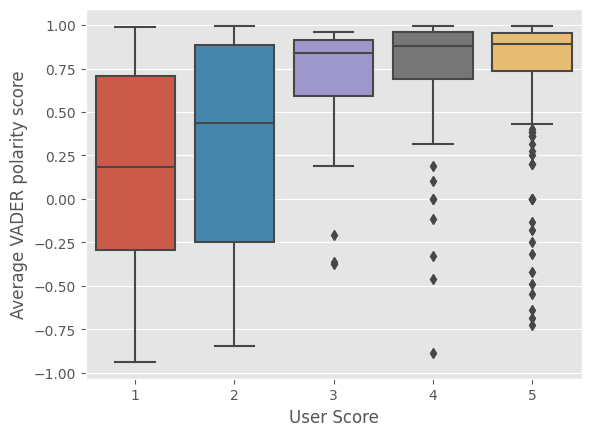

In [31]:
sns.boxplot(data=vaders,x='Score', y='compound' ) 
plt.xlabel('User Score')
plt.ylabel('Average VADER polarity score')

The chart above shows the average polarity score by the user sentiment. This implies that the VADER model performs very well generally in classifying the sentiment of the reviews

In [19]:
# splitting the compound variable into 5 sections for each review
def classify(value):

    if value <= -0.6:
        return 1
    elif value <=-0.2:
        return 2
    elif value <=0.2:
        return 3
    elif value <=0.6:
        return 4
    else:
        return 5

In [20]:
vaders['vader_score'] = vaders['compound'].apply(classify)

In [23]:
from sklearn.metrics import classification_report
print(classification_report(vaders.Score, vaders.vader_score))


              precision    recall  f1-score   support

           1       0.47      0.15      0.23        46
           2       0.20      0.14      0.17        28
           3       0.04      0.03      0.04        29
           4       0.12      0.09      0.10        76
           5       0.72      0.86      0.78       321

    accuracy                           0.59       500
   macro avg       0.31      0.26      0.26       500
weighted avg       0.54      0.59      0.55       500



<AxesSubplot:xlabel='score', ylabel='count'>

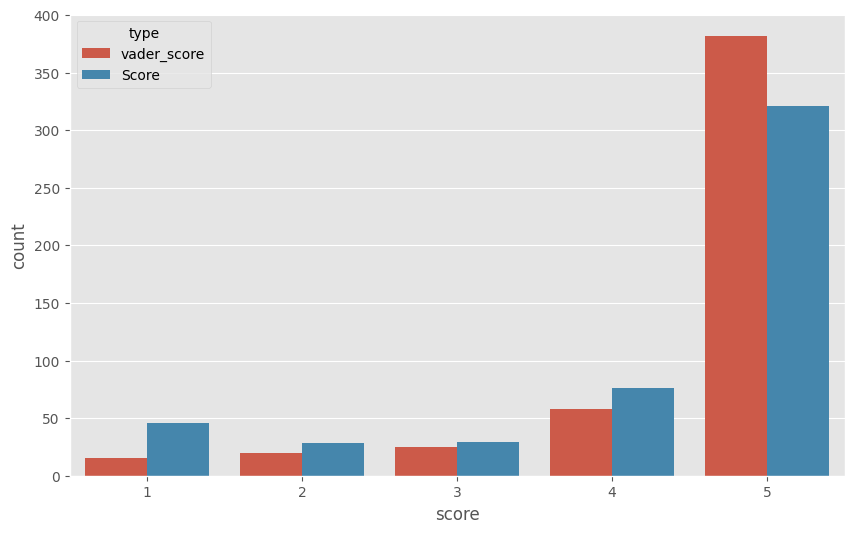

In [22]:
vader_counts = vaders['vader_score'].value_counts().reset_index()
vader_counts.columns = ['score', 'count']
vader_counts['type'] = 'vader_score'

score_counts = vaders['Score'].value_counts().reset_index()
score_counts.columns = ['score', 'count']
score_counts['type'] = 'Score'

# Combine the two DataFrames
combined_counts = pd.concat([vader_counts, score_counts])

# Create the bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='score', y='count', hue='type', data=combined_counts)

## **ANALYSIS OF THE roBERTa MODEL**

In [33]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [34]:
model = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForSequenceClassification.from_pretrained(model)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HP\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]